# Molecular Dynamics Tutorial

In today's lecture, we will be getting hand's on experience with running molecular dynamics simulations.

TODO:

In [1]:
# !pip install simlify==0.0.0.post73

## Selecting protein

villin headpiece

Wild type

-   [1YU5](https://www.rcsb.org/structure/1YU5)
-   [2RJY](https://www.rcsb.org/structure/2RJY)

Mutant

-   [3MYA](https://www.rcsb.org/structure/3MYA)
-   [3MYC](https://www.rcsb.org/structure/3MYC)



In [2]:
import urllib3

In [3]:
def fetch_pdb(pdb_id):
    pdb_id = pdb_id.upper()
    request = urllib3.request(
        "GET",
        f"http://files.rcsb.org/download/{pdb_id}.pdb",
    )
    return request.data.decode("utf-8")

In [4]:
pdb_id_sel = "1YU5"
pdb_text = fetch_pdb(pdb_id_sel)
print(pdb_text)

HEADER    STRUCTURAL PROTEIN                      11-FEB-05   1YU5              
TITLE     CRYSTAL STRUCTURE OF THE HEADPIECE DOMAIN OF CHICKEN VILLIN           
COMPND    MOL_ID: 1;                                                            
COMPND   2 MOLECULE: VILLIN;                                                    
COMPND   3 CHAIN: X;                                                            
COMPND   4 FRAGMENT: HEADPIECE;                                                 
COMPND   5 ENGINEERED: YES                                                      
SOURCE    MOL_ID: 1;                                                            
SOURCE   2 ORGANISM_SCIENTIFIC: GALLUS GALLUS;                                  
SOURCE   3 ORGANISM_COMMON: CHICKEN;                                            
SOURCE   4 ORGANISM_TAXID: 9031;                                                
SOURCE   5 EXPRESSION_SYSTEM: ESCHERICHIA COLI BL21(DE3);                       
SOURCE   6 EXPRESSION_SYSTEM

## Protein preparation

In [5]:
def filter_lines(pdb_text, keep_waters=False):
    # Split the text into structures using "MODEL" and "ENDMDL" as delimiters
    structures = pdb_text.split("ENDMDL")
    filtered_structures = []

    for structure in structures:
        if "MODEL" in structure:
            # Filter each structure's lines
            if keep_waters:
                filtered_lines = "\n".join(
                    [
                        line
                        for line in structure.split("\n")
                        if "HETATM" in line[:6] or "ATOM" in line[:4]
                    ]
                )
            else:
                filtered_lines = "\n".join(
                    [line for line in structure.split("\n") if "ATOM" in line[:4]]
                )
            filtered_structures.append(filtered_lines)

    # Combine filtered structures, adding back the "ENDMDL" tag if needed
    return "ENDMDL\n".join(filtered_structures)


pdb_lines = filter_lines(pdb_text)
with open("protein.pdb", "w", encoding="utf-8") as f:
    f.writelines(pdb_lines)

In [6]:
from openmm import *
from openmm.app import *
from openmm.unit import *

In [7]:
pdb = PDBFile("protein.pdb")

In [8]:
modeller = Modeller(pdb.topology, pdb.positions)
forcefield = ForceField("amber14-all.xml", "amber14/tip3pfb.xml")
modeller.addHydrogens(forcefield)
modeller.addSolvent(forcefield, model="tip3p", padding=1 * nanometer)

In [9]:
system = forcefield.createSystem(
    modeller.topology, nonbondedMethod=PME, constraints=HBonds
)
temperature = 300 * kelvin
pressure = 1 * bar
integrator = LangevinIntegrator(temperature, 1 / picosecond, 2 * femtoseconds)
system.addForce(MonteCarloBarostat(pressure, temperature))
simulation = Simulation(modeller.topology, system, integrator)

## Minimization

In [10]:
simulation.context.setPositions(modeller.positions)
simulation.minimizeEnergy(maxIterations=100)
positions = simulation.context.getState(getPositions=True).getPositions()
with open("init.pdb", "w") as f:
    PDBFile.writeFile(simulation.topology, positions, f)

In [12]:
from sys import stdout

In [13]:
simulation.reporters = []
simulation.reporters.append(DCDReporter("traj.dcd", 10))
simulation.reporters.append(
    StateDataReporter(stdout, 100, step=True, temperature=True, elapsedTime=True)
)
simulation.reporters.append(
    StateDataReporter(
        "scalars.csv",
        10,
        step=True,
        time=True,
        potentialEnergy=True,
        totalEnergy=True,
        temperature=True,
    )
)
simulation.step(30000)

#"Step","Temperature (K)","Elapsed Time (s)"
100,142.996581060354,6.365776062011719e-05
200,179.11635121091737,0.3527684211730957
300,207.010634340577,0.711251974105835
400,227.94262704357058,1.06679105758667
500,242.97882318827544,1.4290897846221924
600,251.97964113074474,1.7777037620544434
700,258.78495395486686,2.1359126567840576
800,269.21571877738427,2.487353563308716
900,274.54040127217684,2.839407444000244
1000,278.51455631082877,3.1975371837615967
1100,282.9513176249905,3.5495352745056152
1200,285.9716714313994,3.9019365310668945
1300,292.2168234045608,4.249464750289917
1400,290.426180916522,4.601815223693848
1500,291.8683857347458,4.953837156295776
1600,291.25604650617186,5.30609130859375
1700,291.4288900673694,5.666704416275024
1800,293.4289585879189,6.016399145126343
1900,291.9315562761669,6.365700721740723
2000,294.35949605685227,6.725806951522827
2100,298.3411605055102,7.076521158218384
2200,294.13247971257766,7.4314117431640625
2300,297.2704133487952,7.786245107650757
240

## Analysis

In [14]:
import pandas as pd

<Axes: xlabel='Time (ps)'>

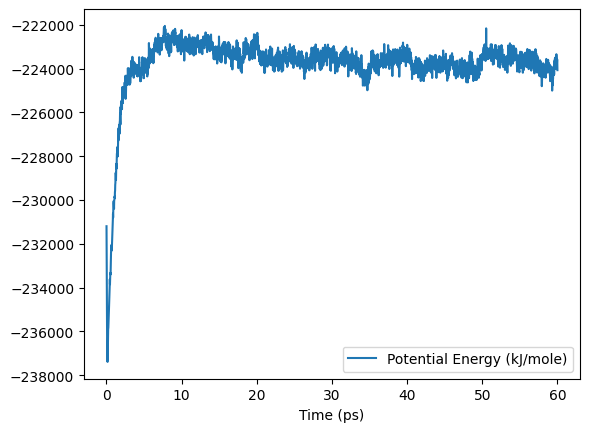

In [16]:
df = pd.read_csv("scalars.csv")
df.plot(kind="line", x="Time (ps)", y="Potential Energy (kJ/mole)")